# LSTM baseline

from kuto

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
import os
import sys
import glob
import pickle
import random

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [6]:
sys.path.append('../../')
import src.utils as utils

In [7]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [8]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [9]:
configs = {
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.01,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [10]:
# config
config = configs

# globals variable
SEED = 777
MAX_EPOCHS = 200
N_SPLITS = 5
DEBUG = False
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 22
IS_SAVE = True

utils.set_seed(SEED)

In [11]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [12]:
train_df = pd.read_csv(WIFI_DIR / 'train_all.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_all.csv')

In [13]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [14]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]

In [15]:
train_df.iloc[:, 100:110]

,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,rssi_9
0,-32,-39,-47,-48,-48,-49,-51,-52,-54,-56
1,-29,-34,-47,-48,-48,-49,-52,-52,-52,-53
2,-33,-39,-48,-48,-49,-52,-54,-55,-55,-55
3,-46,-48,-49,-50,-51,-52,-54,-56,-57,-57
4,-42,-49,-51,-51,-52,-53,-54,-55,-55,-55
...,...,...,...,...,...,...,...,...,...,...
258120,-53,-63,-64,-66,-68,-68,-68,-68,-70,-71
258121,-58,-64,-66,-67,-68,-68,-69,-70,-71,-71
258122,-57,-58,-60,-64,-66,-67,-68,-69,-71,-73
258123,-58,-64,-66,-66,-68,-69,-69,-71,-71,-72


bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [16]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 61206
BSSID TYPES(test): 33042
BSSID TYPES(all): 94248


## preprocessing

In [17]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])

ss = StandardScaler()
ss.fit(train_df.loc[:,RSSI_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
    output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
#     output_df.loc[:,RSSI_FEATS] = ss.transform(output_df.loc[:,RSSI_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

train  

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9,...,rssi_95,rssi_96,rssi_97,rssi_98,rssi_99,x,y,floor,path,site_id
0,52392,35870,2764,34897,52709,35259,42719,33509,23416,15248,...,-79,-79,-79,-79,-79,107.85044,161.892620,-1,5e1580adf4c3420006d520d4,0
1,35870,52392,7486,34897,52709,35259,21970,15248,17024,5350,...,-79,-79,-79,-80,-80,107.85044,161.892620,-1,5e1580adf4c3420006d520d4,0
2,35870,52392,52709,34897,35259,23416,49407,6672,7486,48500,...,-77,-78,-78,-78,-78,98.33065,163.343340,-1,5e1580adf4c3420006d520d4,0
3,23416,34897,35259,52392,35870,3706,49407,15612,10166,4977,...,-75,-76,-76,-77,-77,98.33065,163.343340,-1,5e1580adf4c3420006d520d4,0
4,35870,35259,23416,19472,52392,3706,49407,18305,21409,52794,...,-75,-76,-76,-77,-77,98.33065,163.343340,-1,5e1580adf4c3420006d520d4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,35065,14545,16494,21326,50465,22830,943,30429,43802,32684,...,-84,-85,-85,-85,-85,122.68994,124.028015,6,5dcd5c88a4dbe7000630b084,23
258121,35065,16494,21326,943,50465,22830,30059,33363,59581,14545,...,-85,-85,-85,-85,-85,127.17589,123.677780,6,5dcd5c88a4dbe7000630b084,23
258122,943,35065,14545,16494,21326,22830,50465,30059,48476,59581,...,-84,-84,-85,-85,-85,127.17589,123.677780,6,5dcd5c88a4dbe7000630b084,23
258123,14545,16494,35065,21326,50465,943,30059,48476,58803,22830,...,-85,-85,-85,-85,-85,127.17589,123.677780,6,5dcd5c88a4dbe7000630b084,23


In [18]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [19]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        feature = {
            'BSSID_FEATS':self.bssid_feats[idx],
            'RSSI_FEATS':self.rssi_feats[idx],
            'site_id':self.site_id[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [20]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, bssid_size=94248, site_size=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す       
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        # rssi
        # 次元を64倍に線形変換
        self.rssi = nn.Sequential(
            nn.BatchNorm1d(NUM_FEATS),
            nn.Linear(NUM_FEATS, NUM_FEATS * 64)
        )
        
        concat_size = 64 + (NUM_FEATS * 64) + (NUM_FEATS * 64)
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(concat_size),
            nn.Dropout(0.3),
            nn.Linear(concat_size, 256),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.bssid_embedding(x['BSSID_FEATS'])
        x_bssid = self.flatten(x_bssid)
        
        x_site_id = self.site_embedding(x['site_id'])
        x_site_id = self.flatten(x_site_id)

        x_rssi = self.rssi(x['RSSI_FEATS'])

        x = torch.cat([x_bssid, x_site_id, x_rssi], dim=1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [21]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [22]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [22]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [23]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [24]:
oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path'], groups=train.loc[:, 'path'])):

    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
    
    # model
    model = LSTMModel(wifi_bssids_size, site_count)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=10,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oofs[val_idx, 0] = oof_x
    oofs[val_idx, 1] = oof_y

    
    val_score = mean_position_error(
        oof_x, oof_y, 0,
        val_df['x'].values, val_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)
    

Fold 0


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
wandb: Currently logged in as: sqrt4kaido (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 12.0 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
12.0 M    Trainable params
0         Non-trainable params
12.0 M    Total params
47.893    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 133.6036605834961


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 145.48653975445097


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 127.2880270606137


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 112.31232825215362


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 100.76481730350591


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 92.49715010334741


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 86.97371069617651


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 83.63718358834677


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 81.9276608888674


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 81.31009900119184


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 81.26354193952379


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 61.34679148381299


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 48.52491026034658


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 35.97317895226098


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 29.451582451000004


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 23.966941925319876


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 20.221124328764358


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 17.606561222942887


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 15.945303952145451


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 14.292882997016264


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 13.863837371486248


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 13.175281443731965


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 12.475190784052215


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 11.784038321862194


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 11.230181870557711


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 11.222576286658063


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.887062462510658


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 11.887127100223013


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.925092304109763


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.855164912151055


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 10.714929305705903


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.471004742704025


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.475032619005313


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 11.62119602108946


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 9.633402866736775


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.49332461118837


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.267014461932796


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 9.253471248651149


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 10.062302349103907


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 9.029590416876605


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 9.082016359283678


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 10.392520223694202


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.827362775441582


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.646060955523057


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.656700913335392


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.932160632700578


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 9.201333364221199


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.933123476220622


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.880369613671899


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.206004706523276


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.11695350829154


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.090860728995358


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.083881844213415


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.094327729524537


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.052037813856494


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.075488945678284


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.083724535318328


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.061197009178255


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.070820288005512


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 8.008163958290114


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 8.012546811234346


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 8.006399749273745


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 8.011400841394689


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.998343755192165


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 8.011492525188466


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.995236709819121


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.998458101598065


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 8.002901026293088


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 8.000984609389485


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 8.00415242929964


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 8.010620006801226


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 8.000884070099268


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.9938662555985625


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.99516920511849


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 8.007896639035758


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.993574674358601


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 8.018941509422342


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.999941336199094


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.991800117825934


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 8.003087865132958


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 8.002672675604313


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.9941007488053


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 8.001839580891364


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 8.006971154199066


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.9909289692638215


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 8.003138902016552


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 8.009161019144742


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 8.000734538065533


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 8.001495446231244


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.998296782894057


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.9975372151378705


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 8.00118653280206


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.996264653314181


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.998326421447737


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.9980641433480315
fold 0: mean position error 7.996057851924216
Fold 1


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Loss/val,50.96112
Loss/xy,50.96112
Loss/floor,4.749
MPE/val,7.99606
epoch,93
trainer/global_step,37975
_runtime,789
_timestamp,1618132830
_step,93


Loss/val,█▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▁▁▃▆▇▇▇██████████████████████████████
MPE/val,█▆▅▅▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 12.0 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
12.0 M    Trainable params
0         Non-trainable params
12.0 M    Total params
47.893    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 156.37683868408203


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 125.33253296751579


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 99.49871761488652


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 85.80673498834645


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 80.7049085007647


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 79.65679928334701


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 79.920876663288


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 57.06559042848955


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 43.232186819108755


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 36.899793039498526


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 31.727651988214436


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 26.876595759572297


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 23.223845087572386


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 20.246705346915636


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 18.45086201861631


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 15.998711897561769


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 15.055675021478724


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 13.37649309712645


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 12.688506427469402


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 12.094713127889394


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.472377318080664


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.93928952214325


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 10.629848935933188


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.91763786995765


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.939746260690217


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 9.622979910511157


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.770220300944377


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.405527218467077


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.257802509914391


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.074354019020626


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 11.469840541133093


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.764717970299873


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.783471843928323


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.569019530284661


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.651907821593065


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.693866723859873


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.87385319904734


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 9.033692827652413


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 9.113952731497426


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.72928707721557


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.076176769770921


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.998490756695258


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.974999602433895


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.933220397624848


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.9440311214711405


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.933289640912082


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.936915733879502


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.9153672706212985


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.886342559241249


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.8967593929555155


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.892570495111136


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.878134341487096


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.886449256657026


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.880578331988984


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.8765306284876155


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.875168384458689


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.871253771079301


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.8831171790652315


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.872037547377563


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.891622713829934


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.883152324402131


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.90599476714848


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.88809242401834


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.883759903060744


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.885970531234786


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.888139411735201


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.877558366873269


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.880885666084623


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.887698810118607
fold 1: mean position error 7.884270331759702
Fold 2


Loss/val,48.17767
Loss/xy,48.17767
Loss/floor,5.05313
MPE/val,7.88427
epoch,67
trainer/global_step,27471
_runtime,572
_timestamp,1618133408
_step,67


Loss/val,█▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▁▃▄▅▆▆▆▇▇▇▇▇▇████████████████████████
MPE/val,█▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 12.0 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
12.0 M    Trainable params
0         Non-trainable params
12.0 M    Total params
47.893    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 149.8906707763672


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 133.13536853610321


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 109.14914764786434


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 93.66939646868074


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 85.21663649228539


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 81.47579151951162


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 80.32136083559583


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 80.23283906006854


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 80.42560793583937


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 80.59159194768552


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 56.326952097497845


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 52.68025809128616


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 39.81015671416223


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 33.12431401800957


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 28.17236813236963


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 23.47732840356399


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 19.38321814600923


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 17.009470399591073


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 14.909494458489036


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 13.668026036155315


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 12.980249219293432


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 12.54957263188926


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.56368459749305


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 11.219394638292583


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 11.07190472607843


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.51554660404985


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.892398612356214


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 10.083956479598562


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.93878427506604


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.607625229346176


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.325511482207665


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 10.795674388687765


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.160092603286893


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.973845964141828


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 9.457093181132437


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.045472412053831


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.381157643924151


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.82296585793959


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.869603232237651


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.810626361215956


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.996309338349135


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 9.493993005880313


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.298001680657416


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.129898611212026


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.057427019264786


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.012964226778816


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.964152104983722


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.950259012301162


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.916048900957502


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.930727836456699


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.9026508942050295


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.931545057091244


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.872110749801786


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.888339368023703


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.876674177473065


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.902188820902803


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.878697794779276


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.879561140502548


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.877527488831801


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.849626361500335


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.889833961663443


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.865351843070206


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.881179277912156


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.8396879289257155


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.816028717437593


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.809447801064528


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.80792941515572


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.808350474702527


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.812516428792484


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.806794029879028


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.801620118969321


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.795701379242788


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.793590927723889


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.816846895384525


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.804493993921341


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.812533947395321


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.808943151486218


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.7969996761873


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.799486974539559


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.799872863449603


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.805121320186831


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.797735360955942


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.802336481552035
fold 2: mean position error 7.800562740390006
Fold 3


Loss/val,48.85476
Loss/xy,48.85476
Loss/floor,4.9292
MPE/val,7.80056
epoch,81
trainer/global_step,33127
_runtime,693
_timestamp,1618134107
_step,81


Loss/val,█▅▄▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▁▁▇▆▆▇▇▇▇▇███████████████████████████
MPE/val,█▆▅▅▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 12.0 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
12.0 M    Trainable params
0         Non-trainable params
12.0 M    Total params
47.893    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 141.50956344604492


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 122.67662843427618


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 96.20230981154712


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 85.68585333120427


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 83.01989324846308


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 82.67377237034457


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 64.37644661598449


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 54.504726465366296


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 46.9485446743307


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 40.50341225510221


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 34.68224786683995


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 28.961863396677366


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 24.404529198083896


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 21.71657637233434


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 18.96451538008177


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 16.878656066345766


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 15.33344998524643


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 14.13151994539682


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 14.082793255629896


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 12.575894654484495


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.947500921026107


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 11.50818391110082


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.97776177547946


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.750322607681372


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 11.136350064241546


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.312998754971238


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.423935635866089


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.762701654784125


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.879203783223014


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 10.614337432874658


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.573742972758875


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.29587916430305


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.473697742924276


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.398000037349375


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 9.706874165721041


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.329257718187886


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.168221671427135


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 9.764030722283179


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 9.143403929919787


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.971995944821286


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 9.025466622678637


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 9.020036558818873


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 9.070422332132702


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 9.036505608789158


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 9.045502075135326


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 9.446832664480858


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.947124440421458


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.8376170239368


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 9.095303084285161


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 9.346660405793854


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.670182379032195


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.864984622470987


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.199970703580453


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.139626268832297


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.097811676729677


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.064432384422092


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.060953679337498


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.072564475137826


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.048997271742735


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 8.057347377006161


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 8.047948039693061


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 8.027112597830433


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 8.034748123315579


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 8.026237207522696


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 8.056570729948298


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 8.045037855638205


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 8.043280672241105


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 8.010296594934124


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 8.00174786068356


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.99748959199731


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 8.00049980509052


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.997327048091189


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.995984774363478


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.98660217895019


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.99405517794743


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.9981473604134505


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.994258884714313


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.993240103435571


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.993730881868162


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.9939026831247535


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.995685366140109


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.996225016598932


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.98927489113516


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.9918636113735015
fold 3: mean position error 7.990090556928445
Fold 4


Loss/val,52.42657
Loss/xy,52.42657
Loss/floor,4.88331
MPE/val,7.99009
epoch,82
trainer/global_step,33531
_runtime,699
_timestamp,1618134812
_step,82


Loss/val,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁█▄▅▅▅▅▅▄▄▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
MPE/val,█▆▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 12.0 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
12.0 M    Trainable params
0         Non-trainable params
12.0 M    Total params
47.893    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 151.21664428710938


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 132.1017233114626


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 106.92214067600186


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 91.69409279087357


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 84.19550466000929


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 81.34536177309155


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 80.68853817259355


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 80.73029890439228


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 59.18685117758216


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 53.36296318187503


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 49.826211924922276


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 41.89687101049762


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 33.587018312977435


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 25.775935631220467


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 21.630484286004467


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 18.655667179454255


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 16.633179973320136


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 14.947924227628448


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 13.485346503060573


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 12.67466680643374


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 12.697189159771002


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 11.617060317593253


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.246795488567496


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 11.033494551796933


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.510257753817648


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.616543371159459


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.991194242211922


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.779265081942185


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.630261069293903


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.587458479952938


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.585710618736165


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.711041587103086


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.712620729614152


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.277863739027003


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 9.394884726124998


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.519778791415392


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.2300228625227


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 9.038675243508766


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 9.772803990803421


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 9.336370278271257


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 9.01178408096749


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.960899374233684


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.28233750208353


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.222824895688802


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.212187789379335


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.206493638282469


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.193303534897108


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.16205988561267


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.178574616549387


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.151739098921583


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.161093852065925


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.169057796858187


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.155872989892265


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.132774848004864


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.137958004773184


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.149062259654077


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.168399992572338


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.162081313769209


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.131999548077236


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 8.13350112571783


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 8.119915807265214


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 8.124201795037013


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 8.119420223547126


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 8.120734469558725
fold 4: mean position error 8.116532386676596


In [31]:
oofs_df = pd.DataFrame(oofs, columns=['oof_x', 'oof_y'])
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

,oof_x,oof_y
0,114.615784,158.346695
1,111.784546,158.115051
2,109.763290,164.466446
3,107.128891,163.819778
4,102.912308,167.342682
...,...,...
258120,145.027161,123.570038
258121,148.229492,123.502274
258122,148.072235,122.607315
258123,144.296906,119.882324


In [34]:
oofs_score = mean_position_error(
        oofs_df['oof_x'], oofs_df['oof_y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:7.957502773535794


In [37]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean().reindex(sub.index)
all_preds

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,86.392845,105.738586
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.626366,102.731461
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,84.169830,107.197701
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,86.352509,109.977798
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,85.782448,108.050034
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,0,214.127579,90.578957
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,0,210.608505,99.266472
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,0,207.370590,106.086937


In [48]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds['floor'] = simple_accurate_99['floor'].values
all_preds.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,86.392845,105.738586
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.626366,102.731461
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,84.169830,107.197701
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,86.352509,109.977798
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,85.782448,108.050034
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,214.127579,90.578957
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,210.608505,99.266472
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,207.370590,106.086937


# Post Proccess

In [103]:
oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv")
sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")

In [104]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [105]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [106]:
tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub_df['site'] = tmp[0]
sub_df['path'] = tmp[1]
sub_df['timestamp'] = tmp[2].astype(float)

In [107]:
used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
train_txts = sum(train_txts, [])

In [108]:
txt_pathes = []
for path in tqdm(sub_df['path'].values):
    txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])

100%|██████████| 10133/10133 [00:00<00:00, 29653.90it/s]


In [109]:
sub_df['txt_path'] = txt_pathes

In [110]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')

626it [01:07,  9.30it/s]


In [111]:
sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

In [112]:
sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

In [115]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [116]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [117]:
sub_df_cm = sub_process(sub_df_cm, train_waypoints)
sub_df_cm

,site,path,timestamp,site_path_timestamp,floor,x,y,floorNo,isTrainWaypoint
0,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000000009,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,90.672251,97.749973,F1,False
1,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000009017,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.336888,101.084263,F1,False
2,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000015326,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,83.591187,106.123180,F1,False
3,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000018763,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.948683,109.875981,F1,False
4,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000022328,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.485083,113.382911,F1,False
...,...,...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000082589,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,210.876894,98.530158,F6,False
10129,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000085758,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,209.045940,102.163562,F6,False
10130,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000090895,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,204.904091,109.086081,F6,False
10131,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000096899,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,197.171374,114.555610,F6,False


In [118]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub_df_cm = add_xy(sub_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in sub_df_cm.groupby(['site','floor']):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub_df_cm_ds = pd.concat(ds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [119]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()

# Calculate the distances
sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )

sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)

sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [123]:
sub_pp = sub_pp.reindex(sub.index)
sub_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,80.718400,107.197110,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.695300,111.917800,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,215.262270,97.973610,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.511300,107.841324,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,197.171374,114.555610,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6


In [124]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)

In [25]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

Loss/val,55.20833
Loss/xy,55.20833
Loss/floor,4.40498
MPE/val,8.26543
epoch,199
trainer/global_step,80799
_runtime,957
_timestamp,1616836981
_step,199


Loss/val,█▇▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▇▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▆▆▆▆▆▆▅█▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
MPE/val,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


CV_score,8.13423
_runtime,2
_timestamp,1616837013
_step,0


CV_score,▁
_runtime,▁
_timestamp,▁
_step,▁


In [129]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5dbc1d84c1eb61796cf7c010 - floor - F3'}, xlabel='x_'>)

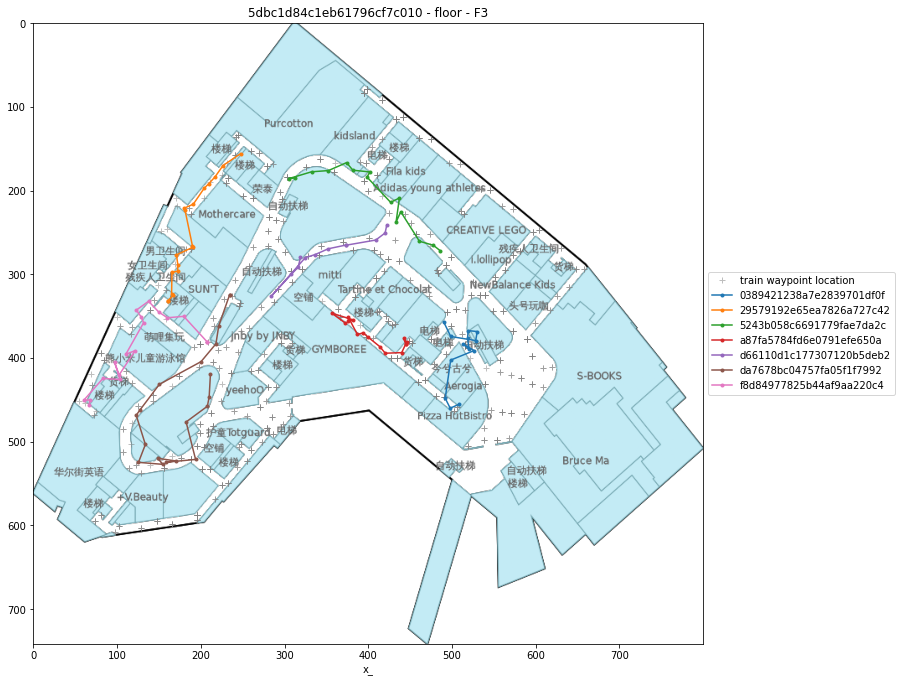

In [136]:
example_site = '5dbc1d84c1eb61796cf7c010'
example_floorNo = 'F3'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5dbc1d84c1eb61796cf7c010 - floor - F3'}, xlabel='x_'>)

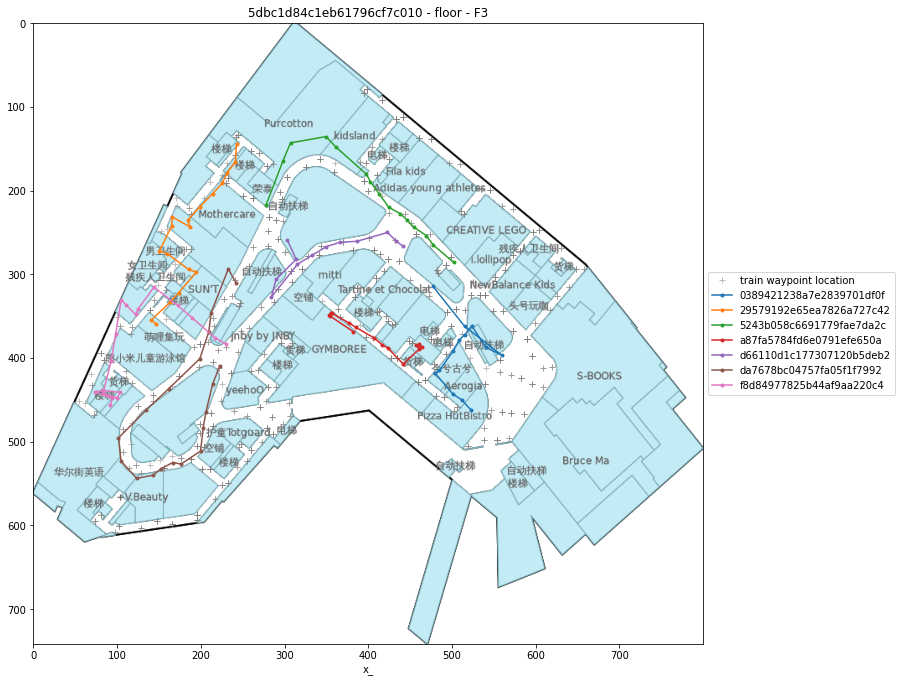

In [135]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5dbc1d84c1eb61796cf7c010 - floor - F3'}, xlabel='x_'>)

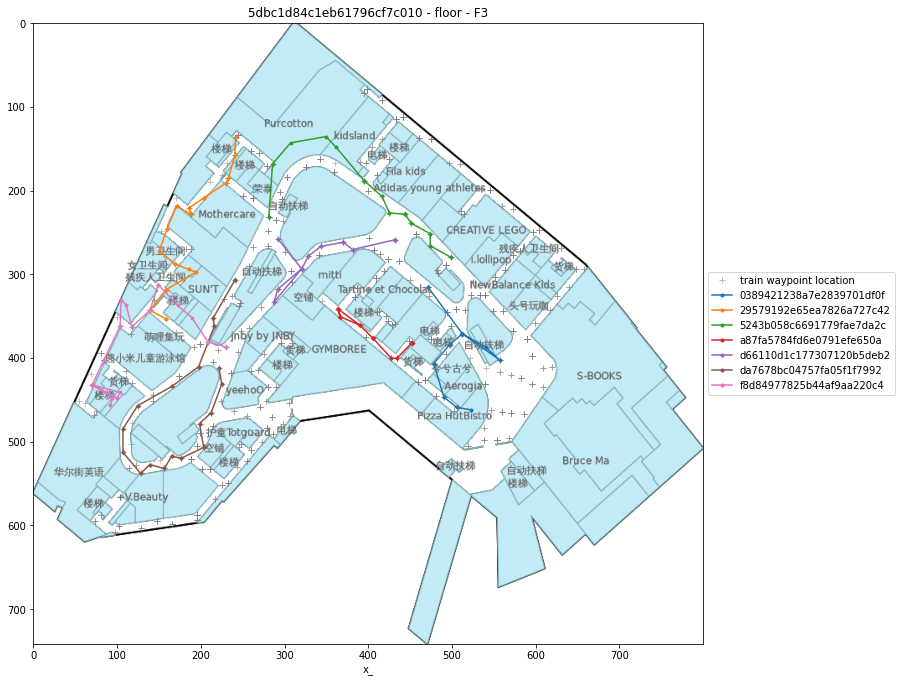

In [132]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)